# Classificazione di vini attraverso gaussiane bidimensionali

<img src="img/wine.jpg" width="30%"/>

Il nostro primo modello generativo per la classificazione di vini utilizzava una sola feature. Ora utilizzeremo due feature, modellando ogni classe con una **gaussiana bivariata**. 

## 1. Caricamento del dataset

Come nel caso univariato, iniziamo caricando il dataset. 

Ricordiamo che vi sono 178 osservazioni, ognuna con 13 feature ed una etichetta (1,2,3). Come prima, le divideremo in un training set di 130 osservazioni ed un test set di 48 osservazioni. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Modulo utile per gestire distribuzioni gaussiane
from scipy.stats import norm, multivariate_normal 
# Pacchetti per la grafica interattiva
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

In [2]:
# Carichiamo il dataset
data = np.loadtxt('data/wine.data.txt', delimiter=',')
# Nomi delle feature
featurenames = ['Alcool', 'Acido malico', 'Ceneri', 'Alcalinità delle ceneri', 'Magnesio', 'Fenoli totali', 
               'Flavonoidi', 'Fenoli non flavonoidi', 'Proantocianina', 'Intensità di colore', 'Tonalità',
              'OD280/OD315', 'Prolina']
# Suddividiamo le 178 istanze in un training set (trainx, trainy) di taglia 130 e un test set (testx, testy) di taglia 48
np.random.seed(0)
perm = np.random.permutation(178)
trainx = data[perm[0:130],1:14]
trainy = data[perm[0:130],0]
testx = data[perm[130:178], 1:14]
testy = data[perm[130:178],0]

## 2. Costruzione della distribuzione di due feature da ognuna delle cantine

Vogliamo graficare la distribuzione di due feature da qualche particolare cantina. Per far questo, useremo varie funzioni ausiliarie. 

La prima funzione ausiliaria fa il fit di una gaussiana su un dataset, restringendo l'attenzione a delle feature specificate. 

In [3]:
# Fa il fit di una gaussiana su un dataset usando le feature specificate
def fit_gaussian(x, features):
    mu = np.mean(x[:,features], axis=0)
    covar = np.cov(x[:,features], rowvar=0, bias=1)
    return mu, covar

Per esempio, analizziamo la gaussiana ottenuta per la Cantina 1, usando le feature 0 ('alcool') e 6 ('flavonoidi').

In [4]:
f1 = 0
f2 = 6
label = 1
mu, covar = fit_gaussian(trainx[trainy==label,:], [f1,f2])
print("Media:\n" + str(mu))
print("Matrice di covarianza:\n" + str(covar))

Media:
[13.78534884  2.99627907]
Matrice di covarianza:
[[0.23325279 0.07526874]
 [0.07526874 0.15240941]]


Ora, costruiamo una routine che grafichi dei punti campionati da una gaussiana bidimensionale, insieme ad alcune curve di livello. Per fare questo occorre anche decidere che intervalli mostrare su ogni asse. Iniziamo con una piccola funzione ausiliaria che prende in input un array di numeri (valori di un'unica feature) e restituisce il range in cui giacciono questi valori. 

In [5]:
# Trova il range in cui giace un array di valori, e aggiunge un 20% di margine a sinistra e a destra
def find_range(x):
    lower = min(x)
    upper = max(x)
    width = upper - lower
    lower = lower - 0.2 * width
    upper = upper + 0.2 * width
    return lower, upper

Ora definiamo una routine che disegna alcune curve di livello di una gaussiana bidimensionale data. 
La routine riceve come input: 
* `mu`, `cov`: i parametri della gaussiana
* `x1g`, `x2g`: la griglia (lungo i due assi) sulla quale va calcolata la densità di probabilità
* `col`: il colore delle curve di livello

In [6]:
def plot_contours(mu, cov, x1g, x2g, col):
    rv = multivariate_normal(mean=mu, cov=cov)
    z = np.zeros((len(x1g),len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            z[j,i] = rv.logpdf([x1g[i], x2g[j]]) 
    sign, logdet = np.linalg.slogdet(cov)
    normalizer = -0.5 * (2 * np.log(6.28) + sign * logdet)
    for offset in range(1,4):
        plt.contour(x1g,x2g,z, levels=[normalizer - offset], colors=col, linewidths=2.0, linestyles='solid')

La funzione **two_features_plot** riceve in input due feature ed un'etichetta, e grafica la distribuzione di quella coppia di feature per la cantina specificata.

La prima riga ci permette di specificare i parametri interattivamente usando dei cursori. 

In [7]:
@interact_manual( f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1), label=IntSlider(1,1,3,1) )
def two_features_plot(f1,f2,label):
    if f1 == f2: # we need f1 != f2
        print("Le feature f1 ed f2 devono essere distinte.")
        return  
    
    # Prepariamo il grafico
    x1_lower, x1_upper = find_range(trainx[trainy==label,f1])
    x2_lower, x2_upper = find_range(trainx[trainy==label,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Grafichiamo i valori degli esempi di training lungo le due feature selezionate
    plt.plot(trainx[trainy==label, f1], trainx[trainy==label, f2], 'ro')

    # Definiamo una griglia lungo ogni asse; la densità sarà calcolata ad ogni punto della griglia
    res = 200 # risoluzione
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Ora grafichiamo alcune curve di livello della densità di probabilità
    mu, cov = fit_gaussian(trainx[trainy==label,:], [f1,f2])
    plot_contours(mu, cov, x1g, x2g, 'k')
    
    # Infine, mostriamo il grafico
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Cantina ' + str(label), fontsize=14, color='blue')
    plt.show()

interactive(children=(IntSlider(value=0, description='f1', max=12), IntSlider(value=6, description='f2', max=1…

## 3. Costruzione di un fit gaussiano per ciascuna classe

Definiamo ora una funzione che fa il fit di un modello generativo gaussiano per ognuna delle tre classi, ristrette ad una lista di feature date. La funzione restituisce: 
* `mu`: le medie delle gaussiane, una per riga
* `covar`: le matrici di covarianza di ognuna delle gaussiane
* `pi`: la lista dei pesi relativi delle tre classi, con somma 1

In [8]:
# La funzione assume che l'etichetta y vari nell'insieme {1,2,3}
def fit_generative_model(x, y, features):
    k = 3 # numero di classi
    d = len(features) # numero di feature
    mu = np.zeros((k+1,d)) # lista dei vettori delle medie
    covar = np.zeros((k+1,d,d)) # lista delle matrici di covarianza
    pi = np.zeros(k+1) # vettore dei pesi delle classi
    for label in range(1,k+1):
        indices = (y==label)
        mu[label,:], covar[label,:,:] = fit_gaussian(x[indices,:], features)
        pi[label] = float(sum(indices))/float(len(y))
    return mu, covar, pi

Ora grafichiamo le tre gaussiane.

In [9]:
@interact_manual( f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1) )
def three_class_plot(f1,f2):
    if f1 == f2: # we need f1 != f2
        print("Le feature f1 ed f2 devono essere distinte.")
        return  
    
    # Prepariamo il grafico
    plt.figure(figsize=(15,10))
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Grafichiamo i valori degli esempi di training lungo le due feature selezionate
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label-1])

    # Definiamo una griglia lungo ogni asse; la densità sarà calcolata ad ogni punto della griglia
    res = 200 # risoluzione
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Mostriamo il fit gaussiano di ciascuna classe, sulla base delle feature f1, f2
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    for label in range(1,4):
        gmean = mu[label,:]
        gcov = covar[label,:,:]
        plot_contours(gmean, gcov, x1g, x2g, colors[label-1])

    # Infine, mostriamo il grafico
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    #plt.title('Dataset Wine', fontsize=14, color='blue')
    plt.show()

interactive(children=(IntSlider(value=0, description='f1', max=12), IntSlider(value=6, description='f2', max=1…

## 4. Predizione delle etichette per gli esempi di test

Quanto bene riusciamo a predire la classe (1,2,3) sulla base di queste due feature? 

Partiamo con una procedura di testing analoga a quella sviluppata per il caso 1D. 

In [10]:
# Ora testiamo la performance di un modello basato su un sottoinsieme di due feature
@interact( f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1) )
def test_model(f1, f2):
    if f1 == f2: # need f1 != f2
        print("Le feature f1 ed f2 devono essere distinte.")
        return  
    features= [f1,f2]
    mu, covar, pi = fit_generative_model(trainx, trainy, features)
    
    k = 3 # Etichette 1,2,...,k
    nt = len(testy) # Numero di esempi di test
    score = np.zeros((nt,k+1))
    for i in range(0,nt):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + \
            multivariate_normal.logpdf(testx[i,features], mean=mu[label,:], cov=covar[label,:,:])
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # Conteggiamo il numero di predizioni errate
    errors = np.sum(predictions != testy)
    print("Errori di test sulla base delle feature: ", end='')
    for f in features:
        print("'" + featurenames[f] + "'" + " ", end='')
    print()
    print("Errori: " + str(errors) + "/" + str(nt))

interactive(children=(IntSlider(value=0, description='f1', max=12), IntSlider(value=6, description='f2', max=1…

### Esercizio rapido 1

Diverse coppie di feature forniscono un diverso numero di errori di test. 
* Qual è la percentuale di errore minima ottenibile? 
* Quale coppia di feature permette di ottenere questa percentuale minima? 

## 5. La frontiera decisionale

La funzione **show_decision_boundary** riceve in input due feature, costruisce un classificatore sulla base di queste due sole feature, e mostra un grafico che contiene sia i dati di training che la frontiera decisionale. 

Per calcolare la frontiera decisionale, definiamo una griglia densa sullo spazio bidimensionale di input e applichiamo il classificatore ad ogni punto della griglia. La funzione predefinita `pyplot.contour` può poi essere invocata per disegnare la frontiera. 

In [11]:
def show_decision_boundary(f1,f2):
    # Facciamo il fit di una gaussiana ad ogni classe
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    
    # Prepariamo gli assi del grafico
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim([x1_lower,x1_upper])
    plt.ylim([x2_lower,x2_upper])

    # Grafichiamo i punti del training set
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='o', ls='None', c=colors[label-1])

    # Definiamo una griglia densa; ogni punto della griglia sarà classificato dal modello generativo
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Dichiaramo delle variabili aleatorie rappresentanti la distribuzione di ciascuna classe
    random_vars = {}
    for label in range(1,4):
        random_vars[label] = multivariate_normal(mean=mu[label,:],cov=covar[label,:,:])

    # Classifichiamo ogni punto della griglia; memorizziamo il risultato nell'array Z[]
    Z = np.zeros((len(x1g), len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            scores = []
            for label in range(1,4):
                scores.append(np.log(pi[label]) + random_vars[label].logpdf([x1g[i],x2g[j]]))
            Z[i,j] = np.argmax(scores) + 1

    # Grafichiamo le curve di livello
    plt.contour(x1g,x2g,Z.T,3,colors='purple')
    
    # Infine, mostriamo la figura
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.show()

Utilizziamo la funzione soprastante per disegnare la frontiera decisionale sulla base delle feature 0 ('alcool') e 6 ('flavonoidi'). 

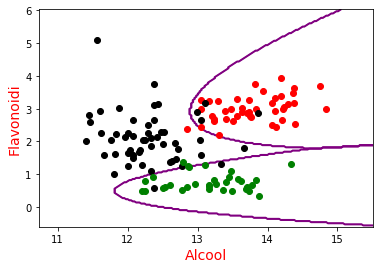

In [12]:
show_decision_boundary(0,6)

### Esercizio rapido 2

Aggiungete dei cursori (slider) interattivi alla funzione **show_decision_boundary**. 

### Esercizio rapido 3

Producete un grafico simile a quello di **show_decision_boundary**, ma in cui siano mostrati solo gli esempi di **test**. Considerate di nuovo la vostra risposta all'*Esercizio rapido 1*. È corroborata dal vostro grafico? Gli errori sono chiaramente visibili? 